In [ ]:
1. Apply dropouts and compare the generalisation performance between SGD and Adam. 
2. Compare the performance of dropouts with weight decay.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report,confusion_matrix

In [3]:
os.chdir("/Users/megannguyen/Desktop/DATA5711/Week3")
dataset = pd.read_csv("precip.csv")

In [4]:
dataset.head()

,lat,lon,Precip,Coal
0,-69.02,-60.78,0.47,0
1,-69.02,77.27,0.69,0
2,-69.02,79.78,0.58,0
3,-62.55,-60.78,0.84,0
4,-48.63,-70.82,2.31,0


<AxesSubplot:>

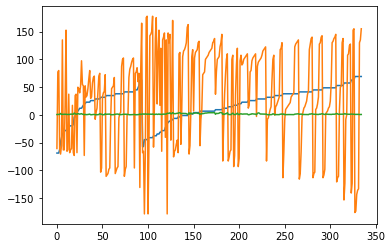

In [5]:
dataset.lat.plot()
dataset.lon.plot()
dataset.Precip.plot()

In [6]:
import torch

In [7]:
X = dataset[["lat","lon","Precip"]]
y = dataset.Coal

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [9]:
X_train = torch.from_numpy(X_train.to_numpy()).type(torch.FloatTensor)
y_train = torch.from_numpy(y_train.to_numpy()).type(torch.FloatTensor)
X_test = torch.from_numpy(X_test.to_numpy()).type(torch.FloatTensor)
y_test = torch.from_numpy(y_test.to_numpy()).type(torch.FloatTensor)

## prepare data for training

Dataset stores the samples and their labels. Dataset retrieves dataset one sample at a time. DataLoader runs iterations on a specifed number of samples to enable easy access to samples (Source: Pytorch.org)

In [10]:
import os
import torch
from torch import nn
import torch.nn.functional as F

In [17]:
from torch.utils.data import Dataset, DataLoader
class TheDataset(Dataset):
    #initialize the directory for X and y
    def __init__(self, X, y):
        self.X = X
        self.y = y
    #len returns the number of samples
    def __len__(self):
        return self.X.shape[0]
    #getitem loads and returns a sample at a given index idx - also converts the samples into tensor form
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [12]:
train_ds = TheDataset(X_train, y_train)
test_ds = TheDataset(X_test, y_test)

In [ ]:
Dataset retrieves dataset one sample at a time. However, when we train our model, we want to pass samples in batch_size then reshuffle data at every epoch to reduce model overfitting 

In [18]:
BATCH_SIZE = 10
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

# build model

In [13]:
model = torch.nn.Sequential(
    torch.nn.Linear(3, 10),
    torch.nn.Tanh(),
    torch.nn.Linear(10, 5),
    torch.nn.ReLU(),
    torch.nn.Linear(5, 1)
)

In [ ]:
.backward computes gradients
.step updates the parameters
scheduler adjusts the learning rate. Most learning rate schedulers can be called back-to-back (also referred to as chaining schedulers). The result is that each scheduler is applied one after the other on the learning rate obtained by the one preceding it.

In [14]:
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer2 = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
torch.optim.swa_utils implements Stochastic Weight Averaging (SWA)
1. SWA uses a modified learning rate schedule so that SGD continues to explore the set of high-performing networks instead of simply converging to a single solution 
2. SWA averages the weights of the networks traversed by SGD. SGD solutions will always be found near the boundary of the flat region of the loss. SWA on the other hand averages multiple SGD solutions, which allows it to move towards the center of the flat region.
For example, standard decaying schedule is used for the first 75% of the training and then a cyclical/constant learning rate is used for the remaining 25%.
3. Batch normalization layers compute running statistics of activations during training by making a forward pass on training data using the SWA model once the training is finished

# Example of using SGD

In [19]:
optimizer1 = torch.optim.SGD(model.parameters(), lr=1e-3)
scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optimizer1, gamma=0.9) #Decays the learning rate of each parameter group by gamma every epoch
#SWA
swa_model = torch.optim.swa_utils.AveragedModel(model) #class that implements SWA models and computes the weights of the SWA model 
swa_start = 160
swa_scheduler = torch.optim.swa_utils.SWALR(optimizer1, swa_lr=0.05) #implements the SWA learning rate scheduler that anneals the learning rate from initial value to 0.05, and then keeps it constant within each parameter group
total1 = 0
sum_loss1 = 0
for epoch in range(300):
    for index, (feats,target) in enumerate(train_loader):
    #to make sure DataSet passes all data in dataset
        pred1 = model(feats)
        losses1 = loss_fn(pred1.squeeze(), target)
    #use SGD
        optimizer1.zero_grad()
        losses1.backward()
        optimizer1.step()
#We train the model for a total of 300 epochs and we switch to the SWA learning rate schedule and start to collect SWA averages of the parameters at epoch 160
    if epoch > swa_start:
       swa_model.update_parameters(model)
       swa_scheduler.step()
    else:
        #scheduler adjusts the learning rate based on the number of epochs
        scheduler1.step()

#Utility function that Updates bn statistics for the swa_model at the end and applies the swa_model to every element in the dataloader and computes the activation statistics for each batch normalization layer in the model
torch.optim.swa_utils.update_bn(train_loader, swa_model)
#Use swa_model to calculate losses
pred1_swa = swa_model(feats)
losses1_swa = loss_fn(pred1_swa.squeeze(), target)

batch_size1 = feats.shape[0]
total1 += batch_size1
sum_loss1 += batch_size1*losses1_swa.item()
sum_loss1 = sum_loss1/total1
print(sum_loss1)

/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
0.019102612510323524


In [67]:
total2 = 0
sum_loss2 = 0
pred2 = model(X_train)
losses2 = loss_fn(pred2.squeeze(), y_train)
#use Adam
optimizer2.zero_grad()
losses2.backward()
optimizer2.step()
batch_size2 = X_train.shape[0]
total2 += batch_size2
sum_loss2 += batch_size2*losses2.item()
sum_loss2 = sum_loss2/total2
print(sum_loss2)

0.5411134958267212


If n is the number of hidden units in any layer and p is the probability of retaining a unit, a good dropout net should have at least n/p units

In [96]:
#Add dropouts to neural networks
model_drop = torch.nn.Sequential(
    torch.nn.Linear(3, 20),
    torch.nn.Tanh(),
    torch.nn.Dropout(p=0.8, inplace=False),
    torch.nn.Linear(20, 20),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5, inplace=False),
    torch.nn.Linear(20, 1)
)


In [62]:
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer3 = torch.optim.SGD(model_drop.parameters(), lr=1e-3)
optimizer4 = torch.optim.Adam(model_drop.parameters(), lr=1e-3)

In [97]:
total3 = 0
sum_loss3 = 0
pred3 = model_drop(X_train)
losses3 = loss_fn(pred3.squeeze(), y_train)
#use SGD dropout
optimizer3.zero_grad()
losses3.backward()
optimizer3.step()
batch_size3 = X_train.shape[0]
total3 += batch_size3
sum_loss3 += batch_size3*losses3.item()
sum_loss3 = sum_loss3/total3
print(sum_loss3)

0.8056675791740417


In [98]:
total4 = 0
sum_loss4 = 0
pred4 = model_drop(X_train)
losses4 = loss_fn(pred4.squeeze(), y_train)
#use Adam dropout
optimizer4.zero_grad()
losses4.backward()
optimizer4.step()
batch_size4 = X_train.shape[0]
total4 += batch_size4
sum_loss4 += batch_size4*losses4.item()
sum_loss4 = sum_loss4/total4
print(sum_loss4)

0.9343078136444092


In [105]:
#Add weight decay
optimizer5 = torch.optim.SGD(model_drop.parameters(), lr=1e-3, weight_decay=1e-2)
optimizer6 = torch.optim.Adam(model_drop.parameters(), lr=1e-3, weight_decay=1e-2)

In [102]:
total5 = 0
sum_loss5 = 0
pred5 = model_drop(X_train)
losses5 = loss_fn(pred5.squeeze(), y_train)
#use SGD with weight decay
optimizer5.zero_grad()
losses5.backward()
optimizer5.step()
batch_size5 = X_train.shape[0]
total5 += batch_size5
sum_loss5 += batch_size5*losses5.item()
sum_loss5 = sum_loss5/total5
print(sum_loss5)

0.8544380068778992


In [106]:
total6 = 0
sum_loss6 = 0
pred6 = model_drop(X_train)
losses6 = loss_fn(pred6.squeeze(), y_train)
#use Adam with weight decay
optimizer6.zero_grad()
losses6.backward()
optimizer6.step()
batch_size6 = X_train.shape[0]
total6 += batch_size6
sum_loss6 += batch_size6*losses6.item()
sum_loss6 = sum_loss6/total6
print(sum_loss6)

0.8760693073272705


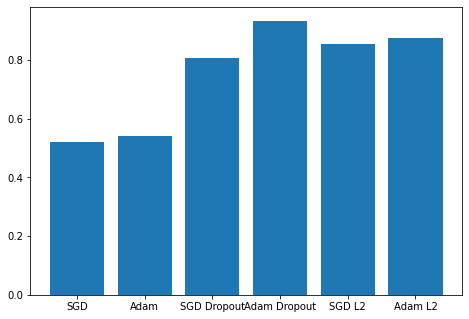

In [107]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
optim = ['SGD','Adam','SGD Dropout','Adam Dropout','SGD L2','Adam L2']
error = [sum_loss1,sum_loss2,sum_loss3,sum_loss4,sum_loss5,sum_loss6]
ax.bar(optim,error)
plt.show()